# Deep Deterministic Policy Gradients (DDPG) Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Start the environment! Before running the code cell below, change the file_name parameter to match the location of the Unity environment that you downloaded as an ABSOLUTE path. The Reacher environment is included in this repo, so, just referring to the file name is enough.

env = UnityEnvironment(file_name="Reacher.app")

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64_S/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

print ('Brain Name:', brain_name)

Brain Name: ReacherBrain


### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Train the agent with ddpg

In [5]:
from collections import deque
import matplotlib.pyplot as plt
from ddpg_agent import Agent
import torch

%matplotlib inline

The following is the Configuration and the setting of the DDPG hyperparameters. They are collected in one cell for easier tuning and experimentation.

In [8]:
# Models: Actor and Critic

# Actor Model Size
Actor_HL1 = 128        # 1st Hidden layer Size
Actor_HL2 = 64         # 2nd Hidden Layer Size

# Critic Model Size
Critic_HL1 = 128       # 1st Hidden layer Size
Critic_HL2 = 64        # 1st Hidden layer Size

# Agent Hyperparametrs (used for training)
BUFFER_SIZE          = int(1e6)   # replay buffer size
BATCH_SIZE           = 128        # minibatch size
GAMMA                = 0.97       # discount factor
TAU                  = 1e-3       # for soft update of target parameters
LR_ACTOR             = 1e-3       # learning rate of the actor
LR_CRITIC            = 1e-3       # learning rate of the critic
WEIGHT_DECAY         = 0.0000     # L2 weight decay

N_EXPERIENCE_UPDATES = 12         # number of learning updates
N_DELAYED_STEPS      = 12         # every n-time steps do update


In [9]:
from collections import deque
import matplotlib.pyplot as plt
from ddpg_agent import Agent
import torch

%matplotlib inline

In [10]:
def ddpg(n_episodes=5, max_t=900, data=None):
    """ Deep Deterministic Policy Gradients
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        data (dict): contains all variables, so you can 
                     happily continue your training where it were left
    """
    if not data:
        scores_window = deque(maxlen=100)
        scores = np.zeros(num_agents)
        scores_episode = []

        agents =[] 

        for i in range(num_agents):
            agents.append(Agent(state_size, action_size, random_seed=0))
    else:
        scores_window = data["scores_window"]
        scores = data["scores"]
        scores_episode = data["scores_episode"]
        agents = data["agents"]
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        for agent in agents:
            agent.reset()
            
        scores = np.zeros(num_agents)
            
        for t in range(max_t):
            actions = np.array([agents[i].act(states[i]) for i in range(num_agents)])
            env_info = env.step(actions)[brain_name]        
            next_states = env_info.vector_observations    
            rewards = env_info.rewards                     
            dones = env_info.local_done        
            
            for i in range(num_agents):
                agents[i].step(t,states[i], actions[i], rewards[i], next_states[i], dones[i]) 
 
            states = next_states
            scores += rewards
        
            if np.any(dones):
                break 
        score = np.mean(scores)
        scores_window.append(score)      
        scores_episode.append(score)

        # print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)), end="\n")
        if i_episode % 25 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(Agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(Agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return {"scores_episode": scores_episode,
            "scores_window": scores_window,
            "scores" : scores,
            "agents": agents
            }

In [11]:
import time

start_time = time.time()                                 # Monitor Training Time
results = ddpg(n_episodes=5000, max_t=1000, data=None)
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

Initialising ReplayBuffer
Episode 25	Average Score: 0.70
Episode 50	Average Score: 1.14
Episode 75	Average Score: 1.28
Episode 100	Average Score: 1.43
Episode 125	Average Score: 1.69
Episode 150	Average Score: 1.77
Episode 175	Average Score: 1.97
Episode 200	Average Score: 2.16
Episode 225	Average Score: 2.26
Episode 250	Average Score: 2.59
Episode 275	Average Score: 2.39
Episode 300	Average Score: 2.19
Episode 325	Average Score: 2.44
Episode 350	Average Score: 2.40
Episode 375	Average Score: 2.69
Episode 400	Average Score: 3.10
Episode 425	Average Score: 3.61
Episode 450	Average Score: 3.89
Episode 475	Average Score: 4.53
Episode 500	Average Score: 4.83
Episode 525	Average Score: 4.96
Episode 550	Average Score: 5.53
Episode 575	Average Score: 5.70
Episode 600	Average Score: 6.23
Episode 625	Average Score: 6.49
Episode 650	Average Score: 6.76
Episode 675	Average Score: 7.43
Episode 700	Average Score: 7.94
Episode 725	Average Score: 8.28
Episode 750	Average Score: 8.79
Episode 775	Avera

### 4. Plotting the learning curve

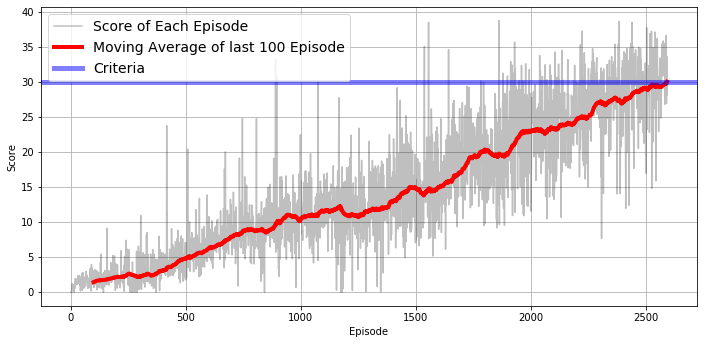

In [12]:
###
import pandas as pd

scores = results["scores_episode"]
Target_Score = 30.0

fig, ax = plt.subplots(1, 1, figsize=[10, 5])
plt.rcParams.update({'font.size': 14})

scores_rolling = pd.Series(scores).rolling(100).mean()
ax.plot(scores, "-", c="black", alpha=0.25)
ax.plot(scores_rolling, "-", c="red", linewidth=4)
ax.set_xlabel("Episode")
ax.set_ylabel("Score")
ax.grid(which="major")
ax.axhline(Target_Score, c="blue", linewidth=5, alpha=0.5)
ax.legend(["Score of Each Episode", "Moving Average of last 100 Episode", "Criteria"])

fig.tight_layout()
fig.savefig("result_score.jpg")


In [13]:
import seaborn as sns

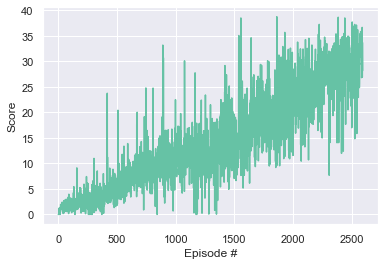

In [18]:

scores = results["scores_episode"]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

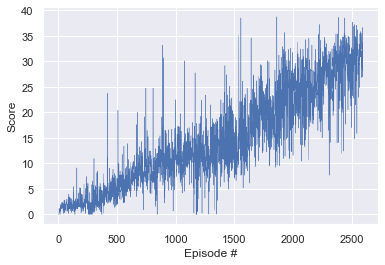

In [16]:

sns.set(style="darkgrid")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores,linewidth=0.4)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

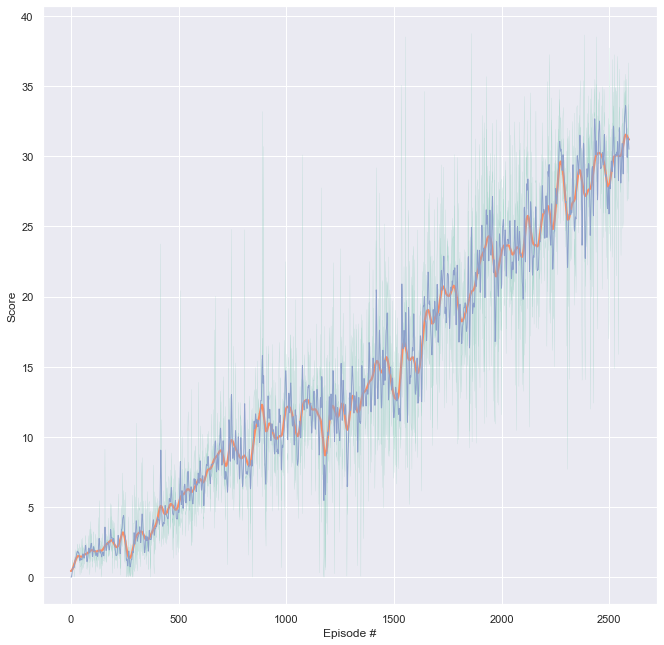

In [17]:

sns.set(style="darkgrid")
sns.set_palette("Set2")
s = scores[:-4]
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed2 = gaussian_filter1d(scores, sigma=2)
ysmoothed3 = gaussian_filter1d(scores, sigma=10)

fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, linewidth=0.1)
plt.plot(np.arange(len(scores)), ysmoothed3, linewidth=2.2)
plt.plot(np.arange(len(scores)), ysmoothed2, linewidth=0.9)

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

 ### 5. Testing the Trained Agent
 
 After traing the Agent we are going to load the wieghts for the actor and critic components of the agent, and then test this agent for one episode (max_t = 1000).



In [53]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

checkpoint_actor_file  = 'checkpoint_actor.pth'
checkpoint_critic_file = 'checkpoint_critic.pth'

agent.actor_local.load_state_dict(torch.load(checkpoint_actor_file))
agent.critic_local.load_state_dict(torch.load(checkpoint_critic_file))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
state    = env_info.vector_observations                # get the current state (for each agent)
scores   = np.zeros(num_agents)                        # initialize the score (for each agent)

for t in range(1000):
    action = agent.act(state, add_noise=False)
    
    env_info = env.step(action)[brain_name]        
    next_state = env_info.vector_observations    
    rewards = env_info.rewards                     
    dones = env_info.local_done
    
    state = next_state
    scores += rewards
    
    if np.any(dones):                                  # exit loop if episode finished
        break 

print('Total score for the Agent in this episode: {}'.format(np.mean(scores)))

Total score for the Agent in this episode: 38.589999137446284


In [ ]:
env.close()